In [9]:
%matplotlib inline
import sigpy as sp
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
plt.style.use('dark_background')
plt.rcParams["savefig.bbox"] = 'tight'

In [10]:
case = "../data/testing/case002"
magn_thresh = 0.00005
maxt1 = 3000
maxt2 = 250

In [11]:
ref = np.load("%s/ref_2min.npy" % case, mmap_mode="r")
ref = sp.fft(ref,axes=(3,))
ref = ref/np.linalg.norm(ref[..., 0].ravel(), ord=np.inf)

In [12]:
deli = np.load("%s/deli_2min.npy" % case, mmap_mode="r")
deli = sp.fft(deli,axes=(3,))
deli = deli/np.linalg.norm(deli[..., 0].ravel(), ord=np.inf)

In [13]:
fin = np.load("%s/refine_2min_iters_20.npy" % case, mmap_mode="r")
fin = sp.fft(fin,axes=(3,))
fin = fin/np.linalg.norm(fin[..., 0].ravel(), ord=np.inf)

In [14]:
# set up basis and dictionary for quantitative fitting
phi = loadmat("../data/shared/phi.mat")["phi"][:, :5]
phi = phi @ sp.fft(np.eye(phi.shape[-1]), axes=(0,))
mat = loadmat("../data/shared/dictionary.mat")

T1 = mat["T1"].ravel()
T2 = mat["T2"].ravel()
mat = mat["I_b"]
(T2, T1) = np.meshgrid(T2, T1)
T1 = T1.ravel()
T2 = T2.ravel()
mat = phi.conj().T @ np.reshape(mat, (-1, mat.shape[-1])).T
nrm = np.linalg.norm(mat, axis=0)
mat = np.array(mat/nrm[None, :],dtype=np.complex64)

In [15]:
def fit(x, dev, mat):
    dev = sp.Device(dev)
    xp = dev.xp
    with dev:
        mat = sp.to_device(mat, dev)
        x = sp.to_device(x, dev)
        
        x     = xp.abs(mat.conj().T @ xp.reshape(x, (5, 256)))
        lst_idx = sp.to_device(xp.argmax(x, axis=0), -1)
        
    fit_T1  = [T1[idx] for idx in lst_idx]
    fit_T2  = [T2[idx] for idx in lst_idx]

    return (fit_T1, fit_T2)

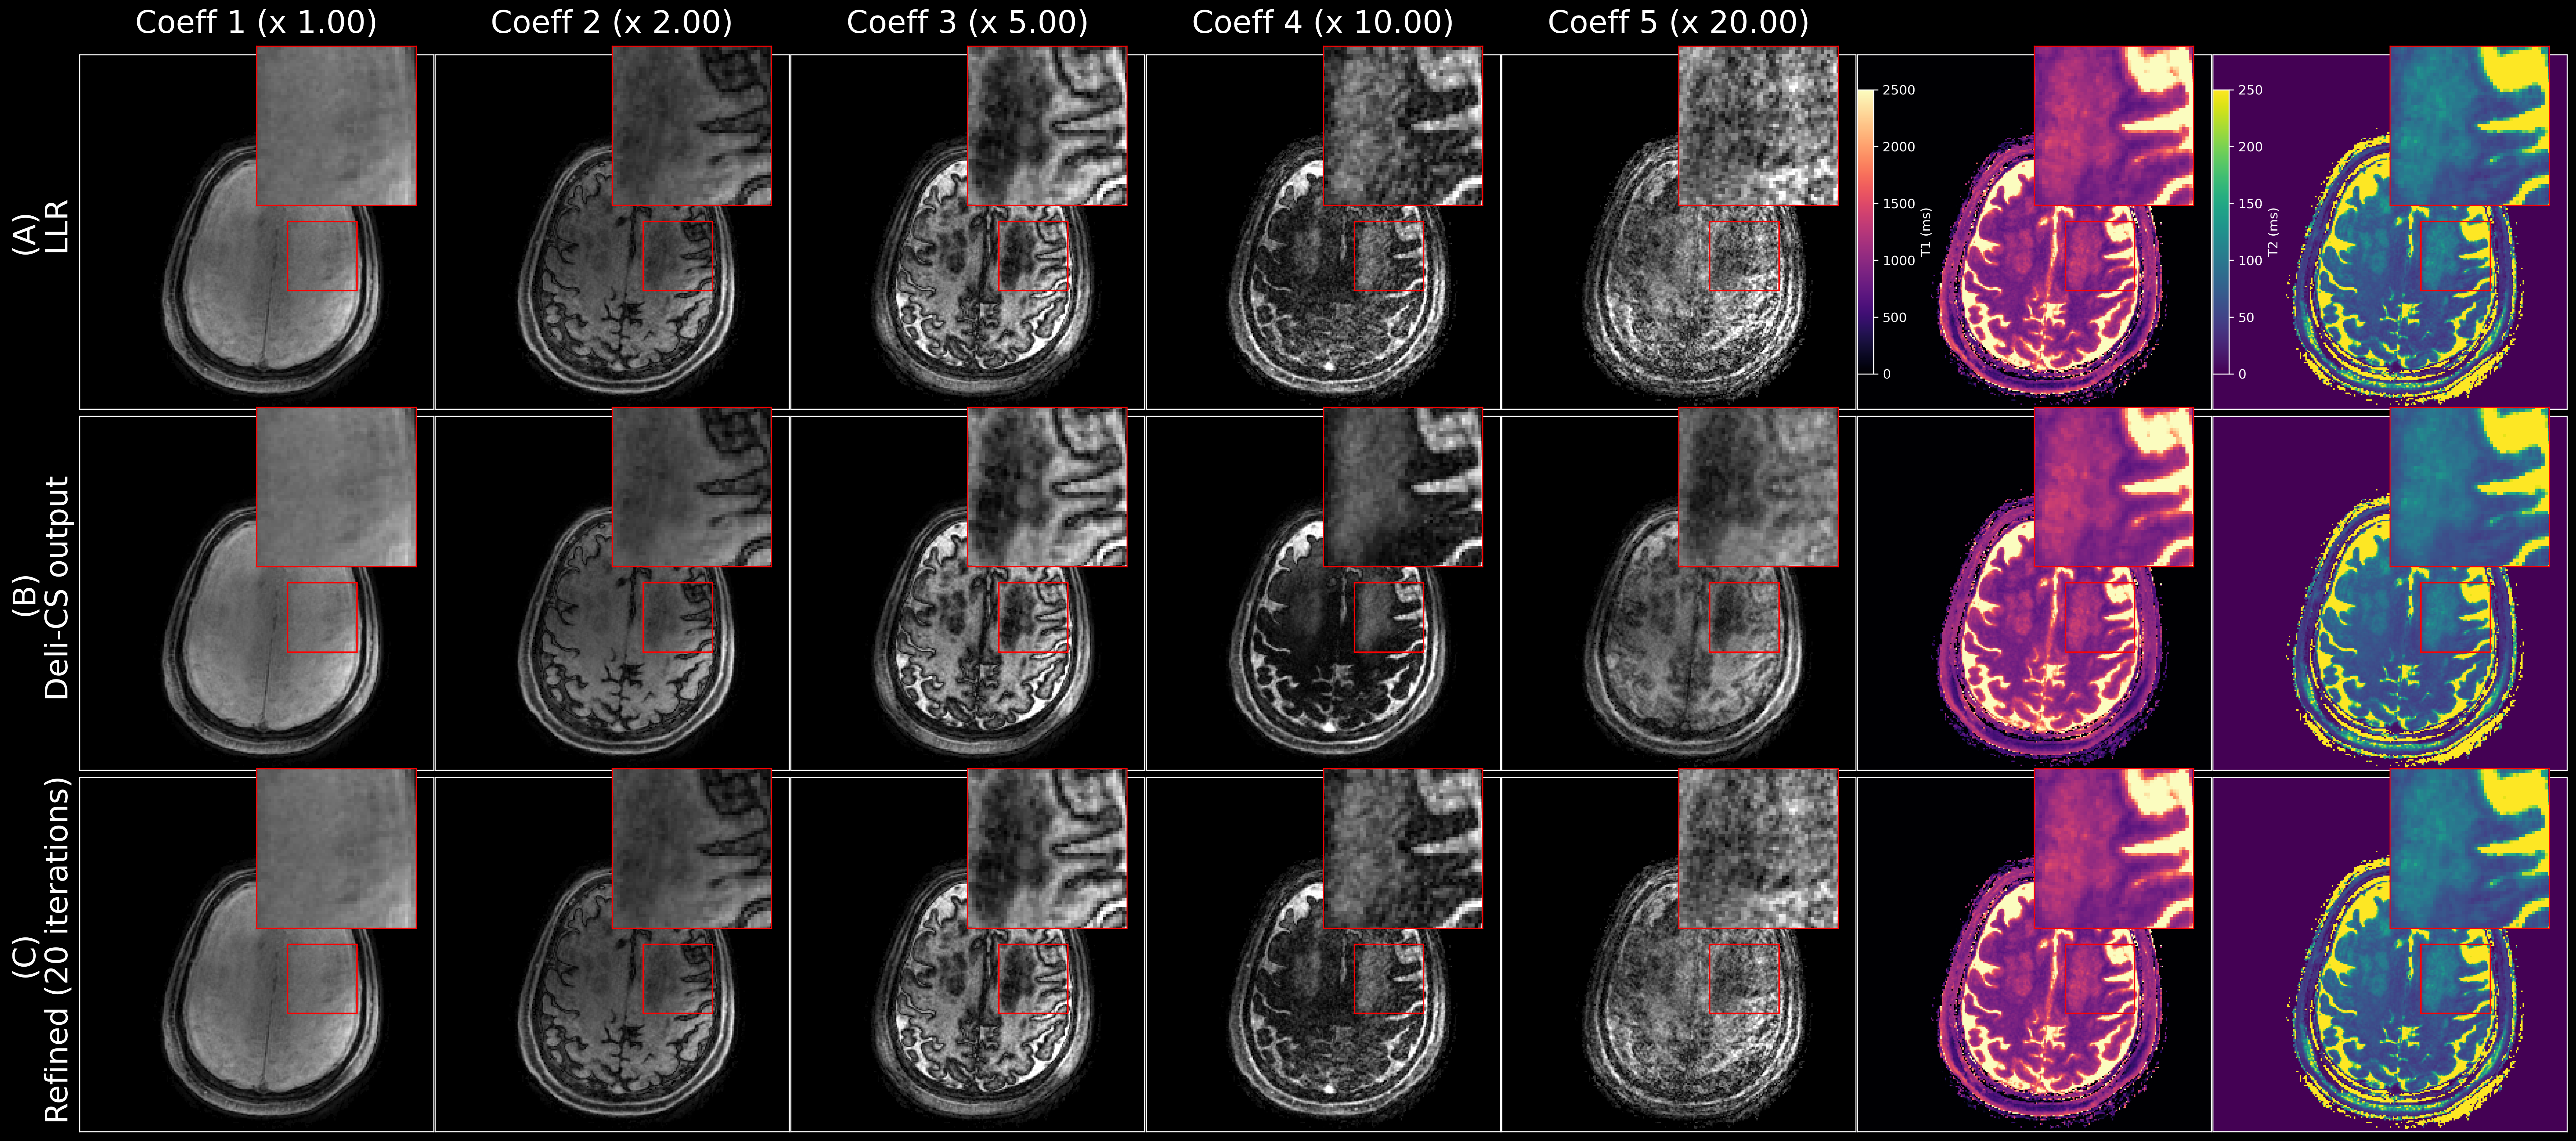

In [16]:
vmax = np.max(np.abs(fin).ravel())*0.5
scales = [1, 2, 5, 10, 20]
tk = fin.shape[-1]
msk = ((np.abs(np.abs(fin)[..., 0])/np.linalg.norm(np.abs(fin)[..., 0])) > magn_thresh)

dev = 0
T1_r1=np.zeros((256,256))
T1_d2=np.zeros((256,256))
T1_d3=np.zeros((256,256))
T2_r1=np.zeros((256,256))
T2_d2=np.zeros((256,256))
T2_d3=np.zeros((256,256))
for lin in range(256):
    (T1_r1[lin,:],T2_r1[lin,:]) = fit(sp.ifft(ref[:,lin,180,:],axes=[-1,]).T,  dev, mat)
    (T1_d2[lin,:],T2_d2[lin,:]) = fit(sp.ifft(deli[:,lin,180,:],axes=[-1,]).T,  dev, mat)
    (T1_d3[lin,:],T2_d3[lin,:]) = fit(sp.ifft(fin[:,lin,180,:],axes=[-1,]).T,  dev, mat)



fig, axs = plt.subplots(3, tk+2, figsize=((tk+2) * 5, 15), dpi=300)

def helper(ax, arr,cm=None,maxr=None):
    if cm == None:
        cm = 'gray'
    if maxr==None:
        maxr=vmax
    tmp = np.abs(arr)
    im = ax.imshow(tmp, cmap=cm, vmin=0, vmax=maxr)
    rect = patches.Rectangle((150, 120), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    
    axins = ax.inset_axes([0.5, 0.575, 0.45, 0.45])
    axins.imshow(tmp, cmap=cm, vmin=0, vmax=maxr)
    axins.set_xlim(150, 200)
    axins.set_ylim(170,  120)
    axins.set_xticks([])
    axins.set_yticks([])
    axins.spines['bottom'].set_color('r')
    axins.spines['top'].set_color('r')
    axins.spines['right'].set_color('r')
    axins.spines['left'].set_color('r')
    return im
    

for k in range(tk):
    helper(axs[0][k], (scales[k]*ref[...,k]*msk)[:, ::-1, 180].T)
    helper(axs[1][k], (scales[k]*deli[...,k]*msk)[:, ::-1, 180].T)   
    helper(axs[2][k], (scales[k]*fin[...,k]*msk)[:, ::-1, 180].T)    
    axs[0][k].set_title("Coeff %d (x %0.2f)" % (k + 1, scales[k]), fontsize=24, pad=10)


helper(axs[0][5], (msk[:, ::-1, 180].T*np.flipud(T1_r1)),'magma',2500)
helper(axs[0][6], (msk[:, ::-1, 180].T*np.flipud(T2_r1)),'viridis',250)
helper(axs[1][5], (msk[:, ::-1, 180].T*np.flipud(T1_d2)),'magma',2500)
helper(axs[1][6], (msk[:, ::-1, 180].T*np.flipud(T2_d2)),'viridis',250)
im1 = helper(axs[2][5], (msk[:, ::-1, 180].T*np.flipud(T1_d3)),'magma',2500)
im2 = helper(axs[2][6], (msk[:, ::-1, 180].T*np.flipud(T2_d3)),'viridis',250)


for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

axs[0][0].set_ylabel("(A)\n LLR", fontsize=24)
axs[1][0].set_ylabel("(B)\n Deli-CS output", fontsize=24)
axs[2][0].set_ylabel("(C)\n Refined (20 iterations)", fontsize=24)


plt.subplots_adjust(wspace=-0.1, hspace=0.02)

box1 = (axs[0][5]).get_position()
axColor = plt.axes([box1.x0, box1.y0+0.025, 0.005, box1.height-0.05])
plt.colorbar(im1, cax=axColor,label='T1 (ms)')
axColor.yaxis.set_ticks_position('right')

box2 = (axs[0][6]).get_position()
axColor = plt.axes([box2.x0, box2.y0+0.025, 0.005, box2.height-0.05])
plt.colorbar(im2, cax=axColor,label='T2 (ms)')
axColor.yaxis.set_ticks_position('right')

plt.savefig('08_compare_recons_patient.png')